# SEG Machine Learning (Well Log Facies Prediction) Contest
### Entry by Justin Gosses of team Pet_Stromatolite

#### This is an "open science" contest designed to introduce people to machine learning with well logs and brainstorm different methods through collaboration with others, so this notebook is based heavily on the introductary notebook with my own modifications.
#### more information at https://github.com/seg/2016-ml-contest
#### and even more information at http://library.seg.org/doi/abs/10.1190/tle35100906.1


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

=================================================================================================================
## Notes:

### Early Ideas for feature engineering
- take out any points in individual wells where not all the logs are present
- test whether error increases around the depths where PE is absent?
- test whether using formation, depth, or depth&formation as variables impacts prediction
- examine well logs & facies logs (including prediction wells) to see if there aren't trends that might be dealt with by increasing the population of certain wells over others in the training set?
- explore effect size of using/not using marine or non-marine flags
- explore making 'likely to predict wrong' flags based on first-pass results with thin facies surrounded by thicker facies such that you might expand a 'blended' response due to the measured response of the tool being thicker than predicted facies
- explore doing the same above but before prediction using range of thickness in predicted facies flags vs. range of thickness in known facies flags
- explore using multiple prediction loops, in order words, predict errors not just facies.
- Explore error distribution: adjacent vs. non-adjacent facies, by thickness, marine vs. non-marine, by formation, and possible human judgement patterns that influence interpreted facies. 

In [142]:
## import modules

from __future__ import division
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize']=(20.0,10.0)
inline_rc = dict(mpl.rcParams)

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from scipy.signal import medfilt

from pandas.tools.plotting import scatter_matrix

import matplotlib.colors as colors

import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from classification_utilities import display_cm, display_adj_cm
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import validation_curve
from sklearn.datasets import load_svmlight_files

from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

seed = 123
np.random.seed(seed)

In [181]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
### in the one below, formation is renamed NM_M and made into floats
# feature_names = ['NM_M','GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
featurePlusFacies_names = ['Facies', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
formation_names = ['A1 LM', 'A1 SH', 'B1 LM', 'B1 SH', 'B2 LM', 'B2 SH', 'B3 LM','B3 SH', 'B4 LM', 'B4 SH', 'B5 LM', 'B5 SH', 'C LM', 'C SH']
## formation_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D','#FAA03F', '#FAA041','#DCAA33','#6AAC00', '#1BAA72']
formation_colors = ['#000000','#00FF00','#0000FF','#FF0000','#01FFFE','#FFA6FE','#FFDB66','#006401','#010067','#95003A','#007DB5','#FF00F6','#FFEEE8','#774D00']                 

In [182]:
### setting up options in pandas
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

In [232]:
# Load data from file
data = pd.read_csv('facies_vectors.csv')

In [233]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [234]:
# mappingFormationIntegers = {'A1 LM':31.0, 'A1 SH':2.0, 'B1 LM':33.0, 'B1 SH':4.0, 'B2 LM':35.0, 'B2 SH':6.0, 'B3 LM':37.0,
#        'B3 SH':8.0, 'B4 LM':39.0, 'B4 SH':10.0, 'B5 LM':41.0, 'B5 SH':12.0, 'C LM':43.0, 'C SH':14.0}

In [292]:
# data = data.replace({'Formation': mappingFormationIntegers})

data.loc[data.Formation == 'A1 LM', 'NM_M'] = 31
data.loc[data.Formation == 'A1 SH', 'NM_M'] = 4
data.loc[data.Formation == 'B1 LM', 'NM_M'] = 33
data.loc[data.Formation == 'B1 SH', 'NM_M'] = 10
data.loc[data.Formation == 'B2 LM', 'NM_M'] = 35
data.loc[data.Formation == 'B2 SH', 'NM_M'] = 16
data.loc[data.Formation == 'B3 LM', 'NM_M'] = 37
data.loc[data.Formation == 'B3 SH', 'NM_M'] = 6
data.loc[data.Formation == 'B4 LM', 'NM_M'] = 45
data.loc[data.Formation == 'B4 SH', 'NM_M'] = 2
data.loc[data.Formation == 'B5 LM', 'NM_M'] = 41
data.loc[data.Formation == 'B5 SH', 'NM_M'] = 12
data.loc[data.Formation == 'C LM', 'NM_M'] = 43
data.loc[data.Formation == 'C SH', 'NM_M'] = 12

In [293]:
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,23.581827,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,15.469115,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,2.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,10.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,31.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,41.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,45.000000,1.000000


In [294]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,4,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,4,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,4,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,4,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,4,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,43,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,43,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,43,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,43,0.661


In [295]:
# data = data.drop('NM_M', 1)

In [296]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,4,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,4,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,4,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,4,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,4,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,43,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,43,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,43,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,43,0.661


In [297]:
# Use the rename function and refer the columns to be renamed. Not all the columns have to be renamed:
# data = data.rename(columns={'Formation': 'NM_M'})

In [298]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,4,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,4,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,4,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,4,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,4,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,43,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,43,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,43,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,43,0.661


### facies_vectors.csv and training_data.csv appear to be the same?

### getting well, depth, facies which are list of all the individual instances of each column (well, depth, facies)

In [299]:
X = data[feature_names].values
# XplusFacies = data[featurePlusFacies_names].values
y = data['Facies'].values

In [300]:
well = data['Well Name'].values
depth = data['Depth'].values
# facies = data['Facies'].values

#### getting list of formations

In [301]:
formation = data['NM_M'].values
np.unique(formation)

array([ 2,  4,  6, 10, 12, 16, 31, 33, 35, 37, 41, 43, 45])

In [302]:
data['Facies'].describe()

count    4149.000000
mean        4.503254
std         2.474324
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Facies, dtype: float64

In [303]:
data[feature_names].describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,64.933985,0.659566,4.402484,13.201066,3.725014,23.581827,0.521852
std,30.302530,0.252703,5.274947,7.132846,0.896152,15.469115,0.286644
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,2.000000,0.000000
25%,44.730000,0.498000,1.600000,8.500000,3.100000,10.000000,0.277000
50%,64.990000,0.639000,4.300000,12.020000,3.551500,31.000000,0.528000
75%,79.438000,0.822000,7.500000,16.050000,4.300000,41.000000,0.769000
max,361.150000,1.800000,19.312000,84.400000,8.094000,45.000000,1.000000


#### quick investigation of these to make sure I understand them

In [304]:
well.shape

(4149,)

In [305]:
facies.shape

(4149,)

In [306]:
np.unique(facies)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [307]:
np.unique(well)

array(['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A',
       'LUKE G U', 'NEWBY', 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN'], dtype=object)

In [308]:
X.size

29043

In [309]:
y.size

4149

### Plotting descriptive visual statistics 

In [310]:

# Define function for plotting feature statistics
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

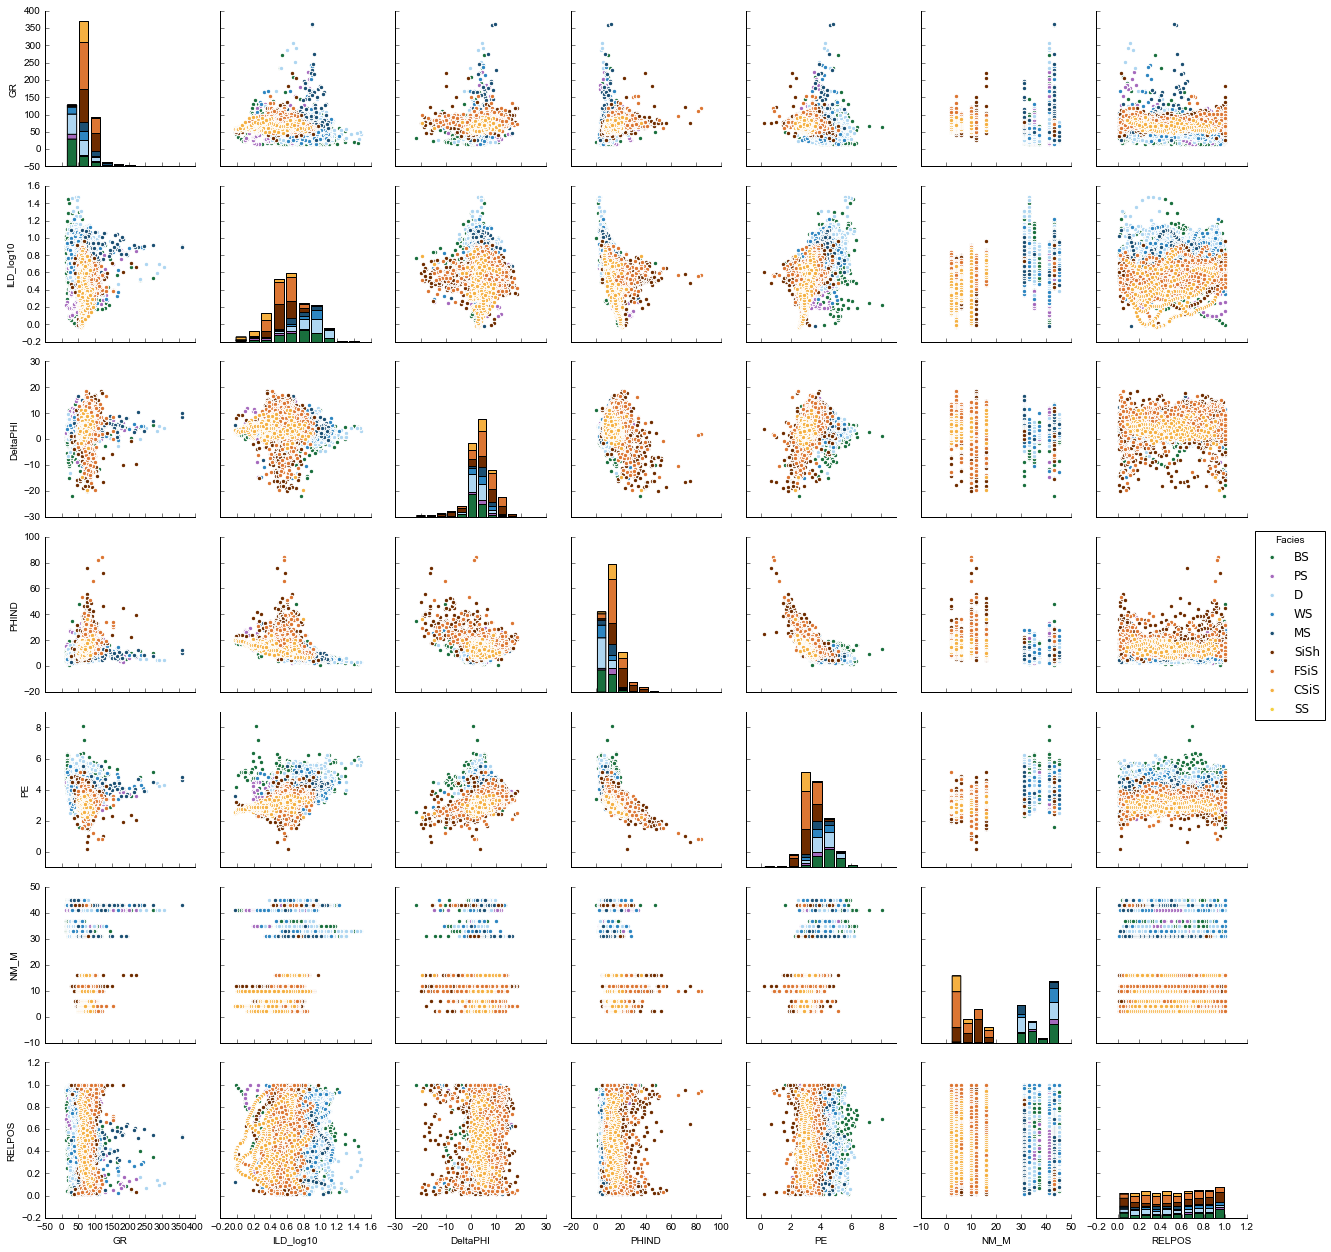

In [311]:
# Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)
mpl.rcParams.update(inline_rc)

### The same as above but with hue as formation instead of facies (note: legend still says 'facies')

using formation_names & formation_colors

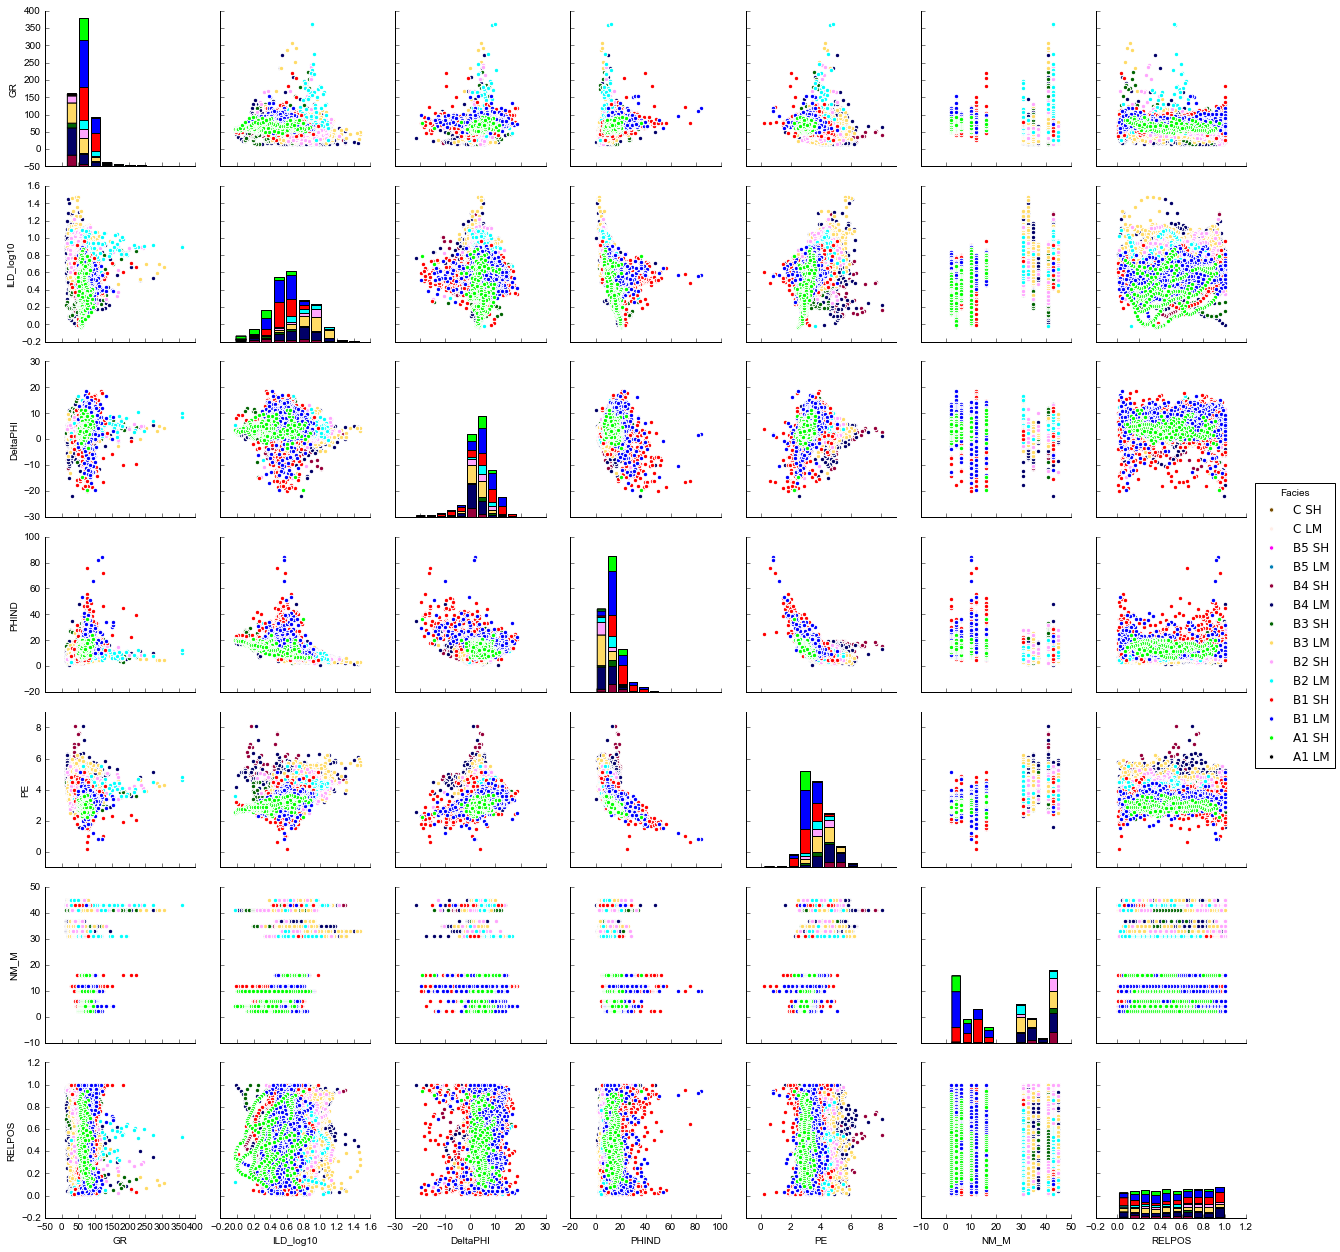

In [312]:
# Feature distribution
plot_feature_stats(X, y, feature_names, formation_colors, formation_names)
mpl.rcParams.update(inline_rc)

### Bar Charts of Number of datapoints of each Facies by well

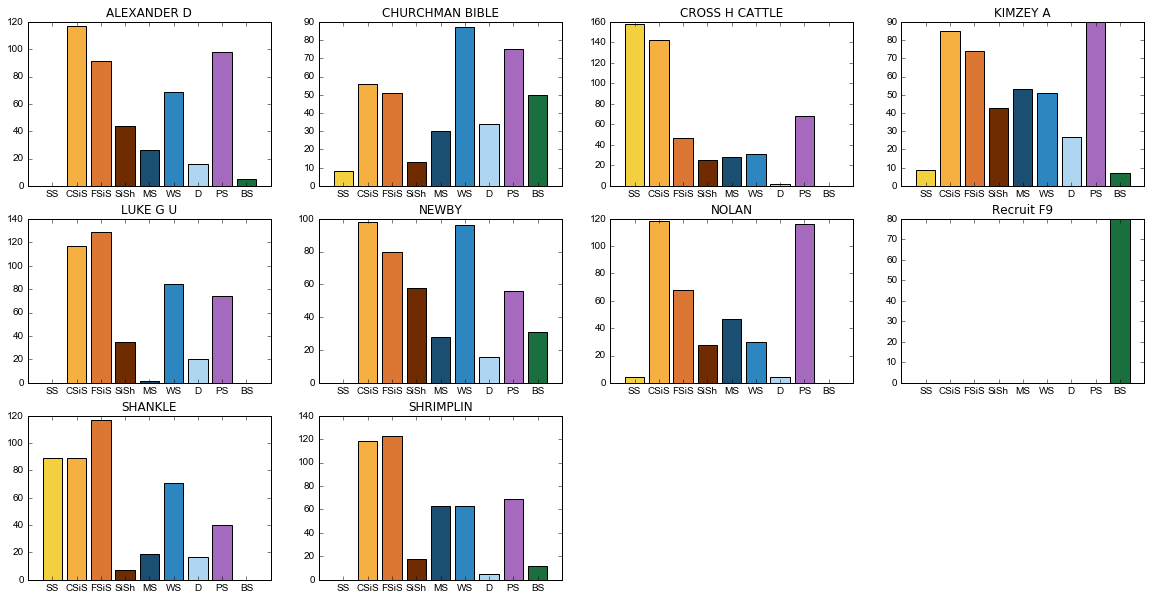

In [313]:
# Facies per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

### Bar Charts of Number of datapoints of each Facies by well

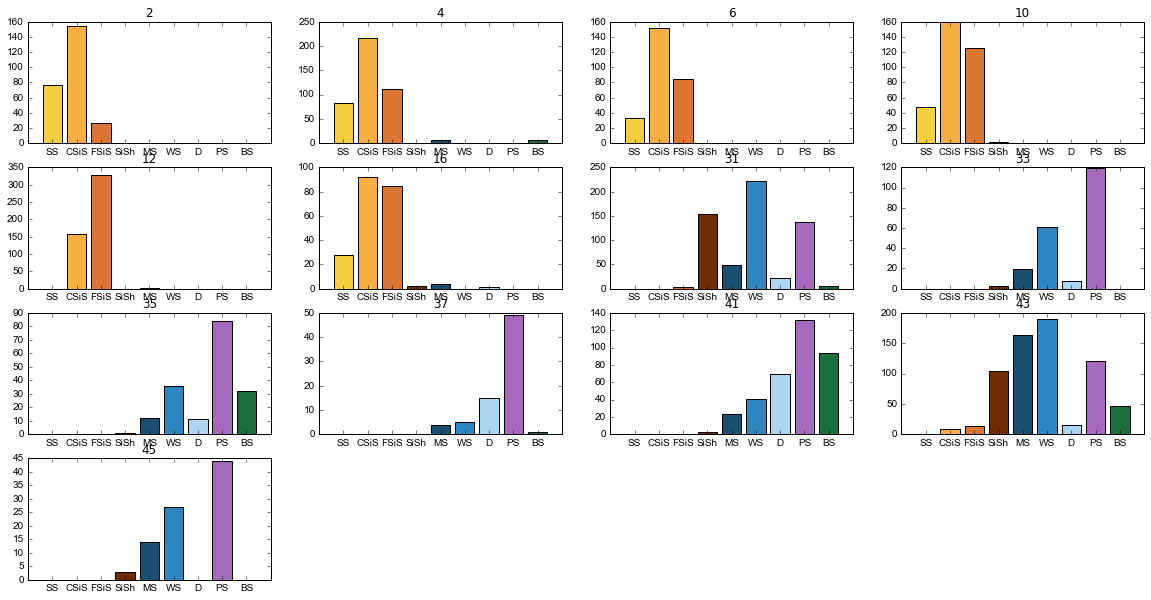

In [314]:
# Facies per formation
for w_idx, w in enumerate(np.unique(formation)):
    ax = plt.subplot(4, 4, w_idx+1)
    hist = np.histogram(y[formation == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

### Checks if every feature is in each well

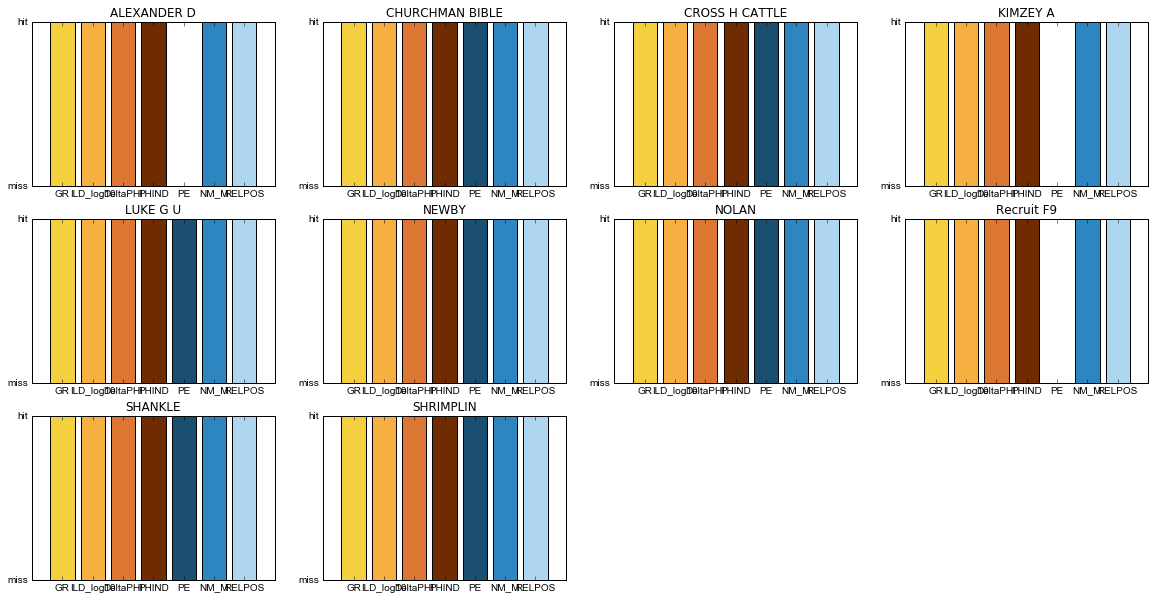

In [315]:
# Features per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['miss', 'hit'])
    ax.set_title(w)

#### PE is missing in several of the wells: Alexander D, Kinzey A, and Recruit F9

In [317]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
DataImpAll = data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

In [318]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [319]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [320]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [321]:
X_aug, padded_rows = augment_features(X, well, depth)

In [322]:
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['ALEXANDER D' 'CHURCHMAN BIBLE']
Split 1
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'Recruit F9' 'NEWBY'
 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'KIMZEY A']
Split 3
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'NOLAN']
Split 4
    training:   ['SHRIMPLIN' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'SHANKLE']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'CHURCHMAN BIBLE'

In [323]:
# Parameters search grid (uncomment parameters for full grid search... may take a lot of time)
md_grid = [3]
mcw_grid = [1]
gamma_grid = [0]
# changed gamma_grid to 0 from 0.3
ss_grid = [0.7]
# changed ss_grid to 0.7 from 1
csb_grid = [0.8]
alpha_grid =[0.2]
lr_grid = [0.05]
ne_grid = [200]
param_grid = []
for N in md_grid:
    for M in mcw_grid:
        for S in gamma_grid:
            for L in ss_grid:
                for K in csb_grid:
                    for P in alpha_grid:
                        for R in lr_grid:
                            for E in ne_grid:
                                param_grid.append({'maxdepth':N, 
                                                   'minchildweight':M, 
                                                   'gamma':S, 
                                                   'subsample':L,
                                                   'colsamplebytree':K,
                                                   'alpha':P,
                                                   'learningrate':R,
                                                   'n_estimators':E})

In [324]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v,well_v):
    
    #Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)


    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    for w in np.unique(well_v):
        y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [325]:
# For each set of parameters
score_param = []
for param in param_grid:
    
    clf = OneVsOneClassifier(XGBClassifier(
            learning_rate = param['learningrate'],
            n_estimators=param['n_estimators'],
            max_depth=param['maxdepth'],
            min_child_weight=param['minchildweight'],
            gamma = param['gamma'],
            subsample=param['subsample'],
            colsample_bytree=param['colsamplebytree'],
            reg_alpha = param['alpha'],
            nthread = 1, 
            # changed nthread to 1 instead of 4 due to running on mac without NVIDA
            seed = seed,
        ) , n_jobs=-1)
    # For each data split
    score_split = []
    for split in split_list:
    
        # Remove padded rows
        split_train_no_pad = np.setdiff1d(split['train'], padded_rows)
        
        # Select training and validation data from current split
        X_tr = X_aug[split_train_no_pad, :]
        X_v = X_aug[split['val'], :]
        y_tr = y[split_train_no_pad]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v)
        
        # Score
        score = f1_score(y_v, y_v_hat, average='micro')
        score_split.append(score)
        
    # Average score for this param
    score_param.append(np.mean(score_split))
    print('F1 score = %.3f %s' % (score_param[-1], param))
          
# Best set of parameters
best_idx = np.argmax(score_param)
param_best = param_grid[best_idx]
score_best = score_param[best_idx]
print('\nBest F1 score = %.3f %s' % (score_best, param_best))

F1 score = 0.568 {'gamma': 0, 'maxdepth': 3, 'n_estimators': 200, 'colsamplebytree': 0.8, 'subsample': 0.7, 'learningrate': 0.05, 'minchildweight': 1, 'alpha': 0.2}

Best F1 score = 0.568 {'gamma': 0, 'maxdepth': 3, 'n_estimators': 200, 'colsamplebytree': 0.8, 'subsample': 0.7, 'learningrate': 0.05, 'minchildweight': 1, 'alpha': 0.2}


In [328]:
for param in param_grid:
    
    clf = OneVsOneClassifier(XGBClassifier(
            learning_rate = param['learningrate'],
            n_estimators=param['n_estimators'],
            max_depth=param['maxdepth'],
            min_child_weight=param['minchildweight'],
            gamma = param['gamma'],
            subsample=param['subsample'],
            colsample_bytree=param['colsamplebytree'],
            reg_alpha = param['alpha'],
            nthread = 1,
#             changed nthread to not be listed, it was 4
            seed = seed,
        ) , n_jobs=-1)

In [329]:
clf

OneVsOneClassifier(estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=200, nthread=1,
       objective='binary:logistic', reg_alpha=0.2, reg_lambda=1,
       scale_pos_weight=1, seed=123, silent=True, subsample=0.7),
          n_jobs=-1)

## Loading test data, running model on it, and exporting predictions

In [344]:
# Load data from file
test_data = pd.read_csv('validation_data_nofacies.csv')

In [345]:
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


### adjusted test data, chaning MN_N column to integers representing Formations

In [346]:
# use formation inplace of NM_M column!
test_data.loc[test_data.Formation == 'A1 LM', 'NM_M'] = 31
test_data.loc[test_data.Formation == 'A1 SH', 'NM_M'] = 4
test_data.loc[test_data.Formation == 'B1 LM', 'NM_M'] = 33
test_data.loc[test_data.Formation == 'B1 SH', 'NM_M'] = 10
test_data.loc[test_data.Formation == 'B2 LM', 'NM_M'] = 35
test_data.loc[test_data.Formation == 'B2 SH', 'NM_M'] = 16
test_data.loc[test_data.Formation == 'B3 LM', 'NM_M'] = 37
test_data.loc[test_data.Formation == 'B3 SH', 'NM_M'] = 6
test_data.loc[test_data.Formation == 'B4 LM', 'NM_M'] = 45
test_data.loc[test_data.Formation == 'B4 SH', 'NM_M'] = 2
test_data.loc[test_data.Formation == 'B5 LM', 'NM_M'] = 41
test_data.loc[test_data.Formation == 'B5 SH', 'NM_M'] = 12
test_data.loc[test_data.Formation == 'C LM', 'NM_M'] = 43
test_data.loc[test_data.Formation == 'C SH', 'NM_M'] = 12

In [347]:
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,4,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,4,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,4,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,4,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,4,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,12,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,12,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,12,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,12,0.556


In [348]:
# Prepare training data
X_tr = X
y_tr = y

# Augment features
X_tr, padded_rows = augment_features(X_tr, well, depth)


# Removed padded rows
X_tr = np.delete(X_tr, padded_rows, axis=0)
y_tr = np.delete(y_tr, padded_rows, axis=0)

In [349]:

# Prepare test data 2
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values



# Augment features
X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

In [350]:
X_ts.shape

(830, 28)

In [351]:
X_tr.shape

(4131, 28)

In [352]:
y_tr.shape

(4131,)

In [353]:
well_ts.shape

(830,)

In [354]:
# Predict test labels
y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts)

In [355]:
# Save predicted labels
test_data['Facies'] = y_ts_hat
test_data.to_csv('Prediction5a.csv')

In [356]:
# print test data
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,4,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,4,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,4,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,4,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,4,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,12,0.639,2
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,12,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,12,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,12,0.556,3


#### Display test data in log form

In [357]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [358]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

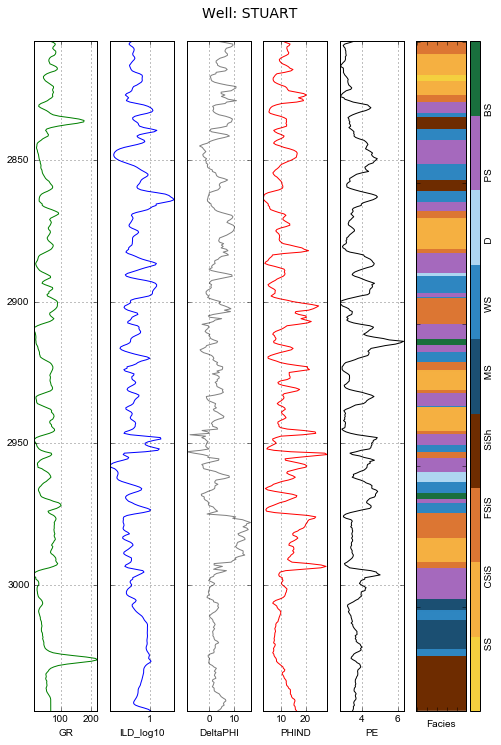

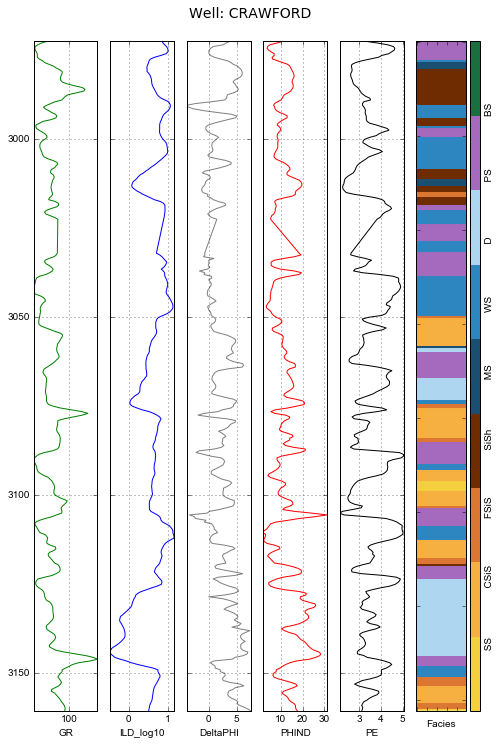

In [359]:
# Plot predicted labels
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)